In [1]:
import sys, platform
print("Python:", sys.version)
print("Env python path:", sys.executable)

Python: 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
Env python path: /opt/anaconda3/bin/python


In [2]:
import sys, subprocess
print("Installing duckdb into:", sys.executable)
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "duckdb"])

Installing duckdb into: /opt/anaconda3/bin/python


0

In [4]:
import duckdb
print("duckdb version:", duckdb.__version__)
duckdb.sql("select 1 as ok").df()

duckdb version: 1.3.2


,ok
0,1


In [5]:
import pandas as pd, duckdb, matplotlib.pyplot as plt

In [7]:
from pathlib import Path
import pandas as pd, duckdb, matplotlib.pyplot as plt

# 1) Use YOUR path (what you sent)
proj_root = Path("/Users/mahithahemadri/Downloads/Projects/SaaS_Revenue_Churn")

# 2) Detect whether CSVs are inside a 'data/' subfolder or directly in the folder
data_dir = proj_root / "data" if (proj_root / "data").exists() else proj_root
print("Using data_dir:", data_dir)

# 3) Verify the 4 required files exist
required = ["accounts.csv","subscriptions.csv","invoices.csv","feature_events.csv"]
missing = [f for f in required if not (data_dir / f).exists()]
if missing:
    raise FileNotFoundError(f"Missing files in {data_dir}: {missing}")
 
# 4) Load the CSVs
accounts  = pd.read_csv(data_dir/"accounts.csv", parse_dates=["created_at"])
subs      = pd.read_csv(data_dir/"subscriptions.csv", parse_dates=["start_date","end_date"])
invoices  = pd.read_csv(data_dir/"invoices.csv", parse_dates=["invoice_month"])
features  = pd.read_csv(data_dir/"feature_events.csv", parse_dates=["month"])

# Quick peek
for name, df in [("accounts",accounts),("subs",subs),("invoices",invoices),("features",features)]:
    print(name, df.shape)
    display(df.head(3))

# 5) Register tables in DuckDB
con = duckdb.connect()
con.register("accounts", accounts)
con.register("subscriptions", subs)
con.register("invoices", invoices)
con.register("feature_events", features)
print("✓ DuckDB registered and ready.")

Using data_dir: /Users/mahithahemadri/Downloads/Projects/SaaS_Revenue_Churn/data
accounts (500, 4)


,account_id,region,segment,created_at
0,ACCT00001,EMEA,Startup,2024-07-01
1,ACCT00002,APAC,MidMarket,2024-03-01
2,ACCT00003,APAC,MidMarket,2024-12-30


subs (744, 8)


,subscription_id,account_id,plan,mrr,discount_rate,start_date,end_date,status
0,SUB00001_1,ACCT00001,Basic,87.84,0.112682,2024-07-26,2025-03-29,churned
1,SUB00002_1,ACCT00002,Basic,92.75,0.063131,2024-07-13,2025-01-06,churned
2,SUB00002_2,ACCT00002,Pro,343.49,0.139111,2025-02-01,2025-08-11,churned


invoices (3792, 6)


,invoice_id,subscription_id,account_id,invoice_month,amount,paid
0,INV0000001,SUB00001_1,ACCT00001,2024-09-01,86.04,1
1,INV0000002,SUB00001_1,ACCT00001,2024-10-01,91.23,1
2,INV0000003,SUB00001_1,ACCT00001,2024-11-01,83.09,1


features (36000, 4)


,account_id,month,feature,monthly_uses
0,ACCT00001,2024-09-01,Dashboards,35
1,ACCT00001,2024-09-01,API,19
2,ACCT00001,2024-09-01,SSO,21


✓ DuckDB registered and ready.


In [9]:
# --- Monthly MRR waterfall (+ NRR) ---
sql_mrr = """
WITH cal AS (SELECT DATE_TRUNC('month', invoice_month)::DATE m FROM invoices GROUP BY 1),
active AS (
  SELECT c.m, s.account_id, s.subscription_id, s.plan, s.mrr
  FROM cal c JOIN subscriptions s
    ON s.start_date <= (c.m + INTERVAL 1 MONTH - INTERVAL 1 DAY)
   AND s.end_date   >= c.m
),
acct AS (SELECT m, account_id, SUM(mrr) mrr FROM active GROUP BY 1,2),
lagg AS (
  SELECT account_id, m, mrr, LAG(mrr) OVER (PARTITION BY account_id ORDER BY m) prev_mrr
  FROM acct
),
comp AS (
  SELECT m,
    SUM(CASE WHEN prev_mrr IS NULL AND mrr>0 THEN mrr ELSE 0 END) new_mrr,
    SUM(CASE WHEN prev_mrr>0 AND mrr>prev_mrr THEN mrr-prev_mrr ELSE 0 END) expansion_mrr,
    SUM(CASE WHEN prev_mrr>0 AND mrr<prev_mrr AND mrr>0 THEN prev_mrr-mrr ELSE 0 END) contraction_mrr,
    SUM(CASE WHEN prev_mrr>0 AND mrr=0 THEN prev_mrr ELSE 0 END) churned_mrr
  FROM lagg GROUP BY 1
),
tot AS (SELECT m, SUM(mrr) total_mrr FROM acct GROUP BY 1)
SELECT t.m, t.total_mrr, c.new_mrr, c.expansion_mrr, c.contraction_mrr, c.churned_mrr,
  ROUND( (t.total_mrr - c.churned_mrr + c.expansion_mrr - c.contraction_mrr)
         / NULLIF(LAG(t.total_mrr) OVER (ORDER BY t.m),0) * 100, 1) AS nrr_pct
FROM tot t JOIN comp c USING(m) ORDER BY m;
"""
mrr = con.execute(sql_mrr).df()

# --- Logo churn (how many customers leave month→month) ---
sql_logo = """
WITH act AS (
  SELECT DATE_TRUNC('month', invoice_month)::DATE m, account_id
  FROM invoices WHERE paid=1 GROUP BY 1,2
)
SELECT a.m,
       COUNT(DISTINCT a.account_id) AS active_logos,
       COUNT(DISTINCT a.account_id) FILTER (WHERE a.account_id NOT IN
         (SELECT account_id FROM act b WHERE b.m = a.m + INTERVAL 1 MONTH)
       ) AS churned_logos
FROM act a
GROUP BY 1 ORDER BY 1;
"""
logos = con.execute(sql_logo).df()

# Adoption → retention using NTILE quintiles (works in DuckDB 1.3.2)
sql_adopt = """
WITH uses AS (
  SELECT month, account_id, SUM(monthly_uses) AS total_uses
  FROM feature_events
  GROUP BY 1,2
),
ret AS (
  SELECT u.month, u.account_id,
         EXISTS (
           SELECT 1
           FROM invoices i
           WHERE i.account_id = u.account_id
             AND DATE_TRUNC('month', i.invoice_month)::DATE = u.month + INTERVAL 1 MONTH
             AND i.paid = 1
         ) AS kept_next
  FROM uses u
),
ranked AS (
  -- Global quintiles across the entire usage distribution
  SELECT
    month, account_id, total_uses,
    NTILE(5) OVER (ORDER BY total_uses) AS adoption_quintile
  FROM uses
)
SELECT
  adoption_quintile,
  AVG(CASE WHEN kept_next THEN 1 ELSE 0 END) AS retention_rate_next_month
FROM ranked r
JOIN ret USING (month, account_id)
GROUP BY 1
ORDER BY 1;
"""
adopt = con.execute(sql_adopt).df()
adopt

,adoption_quintile,retention_rate_next_month
0,1,0.525833
1,2,0.546667
2,3,0.526667
3,4,0.579167
4,5,0.696667


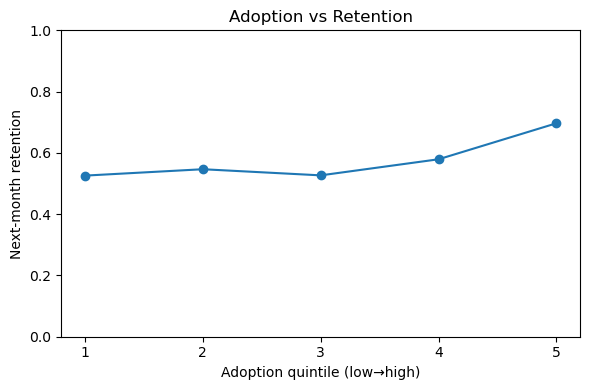

In [10]:
plt.figure(figsize=(6,4))
plt.plot(adopt["adoption_quintile"], adopt["retention_rate_next_month"], marker="o")
plt.xticks([1,2,3,4,5]); plt.ylim(0,1)
plt.xlabel("Adoption quintile (low→high)"); plt.ylabel("Next-month retention")
plt.title("Adoption vs Retention"); plt.tight_layout(); plt.show()

In [11]:
mrr.to_csv("mrr_waterfall.csv", index=False)
logos.to_csv("logo_churn.csv", index=False)
adopt.to_csv("adoption_retention.csv", index=False)
print("Saved: mrr_waterfall.csv, logo_churn.csv, adoption_retention.csv")

Saved: mrr_waterfall.csv, logo_churn.csv, adoption_retention.csv


In [12]:
import numpy as np
mrr2 = mrr.copy()
mrr2["start_mrr"] = mrr2["total_mrr"].shift(1)
mrr2["grr_pct"] = ((mrr2["start_mrr"] - mrr2["contraction_mrr"] - mrr2["churned_mrr"])
                   / mrr2["start_mrr"] * 100).round(1)

nrr_last = float(mrr2["nrr_pct"].dropna().iloc[-1])
grr_last = float(mrr2["grr_pct"].dropna().iloc[-1])

# logo churn last month ≈ churned logos / prior-month active
if len(logos) >= 2:
    logo_churn_last = round(100 * logos["churned_logos"].iloc[-1] /
                            max(1, logos["active_logos"].iloc[-2]), 1)
else:
    logo_churn_last = np.nan

# adoption retention lift: Q5 - Q1
lift = None
try:
    q1 = adopt.loc[adopt["adoption_quintile"]==1,"retention_rate_next_month"].iloc[0]
    q5 = adopt.loc[adopt["adoption_quintile"]==5,"retention_rate_next_month"].iloc[0]
    lift = round(100*(q5 - q1), 1)   # in percentage points
except Exception:
    pass

print(f"Latest NRR: {nrr_last:.1f}%")
print(f"Latest GRR: {grr_last:.1f}%")
print(f"Latest logo churn: {logo_churn_last:.1f}%")
print(f"Adoption retention lift (Q5 - Q1): {lift} pp")

Latest NRR: 97.6%
Latest GRR: 94.3%
Latest logo churn: 93.8%
Adoption retention lift (Q5 - Q1): 17.1 pp


In [13]:
cohort_long = con.execute("""
WITH first_m AS (
  SELECT account_id, MIN(DATE_TRUNC('month', invoice_month)::DATE) AS cohort_m
  FROM invoices WHERE paid=1 GROUP BY 1
),
act AS (
  SELECT DATE_TRUNC('month', invoice_month)::DATE AS m, account_id
  FROM invoices WHERE paid=1 GROUP BY 1,2
),
age AS (
  SELECT a.account_id, f.cohort_m, a.m,
         (EXTRACT(YEAR FROM a.m)*12+EXTRACT(MONTH FROM a.m)) -
         (EXTRACT(YEAR FROM f.cohort_m)*12+EXTRACT(MONTH FROM f.cohort_m)) AS age_m
  FROM act a JOIN first_m f USING(account_id)
)
SELECT cohort_m, age_m, COUNT(DISTINCT account_id) AS active_logos
FROM age GROUP BY 1,2 ORDER BY 1,2;
""").df()

mat = cohort_long.pivot(index="cohort_m", columns="age_m", values="active_logos").fillna(0).astype(int)
size0 = mat.get(0)
retention = mat.div(size0, axis=0).round(3)

cohort_long.to_csv("cohort_active_long.csv", index=False)
retention.to_csv("cohort_retention_matrix.csv")
print("Saved: cohort_active_long.csv, cohort_retention_matrix.csv")
retention.head()

Saved: cohort_active_long.csv, cohort_retention_matrix.csv


age_m,0,1,2,3,4,5,6,7,8,9,10,11
cohort_m,,,,,,,,,,,,
2024-09-01,1.0,0.949,0.927,0.869,0.788,0.745,0.679,0.577,0.577,0.533,0.460,0.38
2024-10-01,1.0,0.930,0.947,0.965,0.842,0.842,0.807,0.702,0.649,0.614,0.526,0.00
2024-11-01,1.0,0.969,0.938,0.906,0.812,0.844,0.812,0.781,0.625,0.719,0.000,0.00
2024-12-01,1.0,0.946,0.929,0.911,0.804,0.643,0.625,0.554,0.589,0.000,0.000,0.00
2025-01-01,1.0,0.964,0.964,0.964,0.911,0.804,0.768,0.679,0.000,0.000,0.000,0.00


In [14]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# ensure you already saved these earlier; if not, re-create quickly:
plt.figure(figsize=(7,4)); plt.plot(mrr["m"], mrr["nrr_pct"], marker="o"); plt.axhline(100, ls="--")
plt.title("NRR % by Month"); plt.tight_layout(); plt.savefig("nrr_trend.png", dpi=180); plt.close()

plt.figure(figsize=(9,4))
plt.bar(mrr["m"], mrr["new_mrr"], label="New")
plt.bar(mrr["m"], mrr["expansion_mrr"], bottom=mrr["new_mrr"], label="Expansion")
plt.bar(mrr["m"], -mrr["contraction_mrr"], label="Contraction")
plt.bar(mrr["m"], -mrr["churned_mrr"], bottom=-mrr["contraction_mrr"], label="Churn")
plt.legend(); plt.title("MRR Waterfall Components"); plt.tight_layout(); plt.savefig("mrr_waterfall_components.png", dpi=180); plt.close()

plt.figure(figsize=(6,4))
plt.plot(adopt["adoption_quintile"], adopt["retention_rate_next_month"], marker="o")
plt.xticks([1,2,3,4,5]); plt.ylim(0,1)
plt.title("Adoption vs Retention"); plt.tight_layout(); plt.savefig("adoption_vs_retention.png", dpi=180); plt.close()

img1 = mpimg.imread("nrr_trend.png")
img2 = mpimg.imread("mrr_waterfall_components.png")
img3 = mpimg.imread("adoption_vs_retention.png")

with PdfPages("SaaS_Revenue_Churn_OnePager.pdf") as pdf:
    fig = plt.figure(figsize=(11, 8.5), constrained_layout=True)
    gs = fig.add_gridspec(2, 3, height_ratios=[0.28, 0.72])

    axh = fig.add_subplot(gs[0, :]); axh.axis("off")
    axh.text(0.01, 0.75, "SaaS Revenue & Churn — One Pager", fontsize=16, fontweight="bold")
    axh.text(0.01, 0.45,
             f"Latest NRR: {nrr_last:.1f}%   |   Latest GRR: {grr_last:.1f}%   |   Logo churn: {logo_churn_last:.1f}%   |   Adoption lift: {lift} pp",
             fontsize=11)

    ax1 = fig.add_subplot(gs[1, 0]); ax1.imshow(img1); ax1.set_title("NRR % by Month"); ax1.axis("off")
    ax2 = fig.add_subplot(gs[1, 1]); ax2.imshow(img2); ax2.set_title("MRR Waterfall Components"); ax2.axis("off")
    ax3 = fig.add_subplot(gs[1, 2]); ax3.imshow(img3); ax3.set_title("Adoption → Retention"); ax3.axis("off")

    pdf.savefig(fig, bbox_inches="tight"); plt.close(fig)

print("Saved: SaaS_Revenue_Churn_OnePager.pdf")

Saved: SaaS_Revenue_Churn_OnePager.pdf
